# Project 6 - Optimizing Group Fitness Class Utilization
## Team 5- Harsh, Hosang, Simran

In [107]:
# Import necessary libraries
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

## Load the Dataset

In [108]:
# Load the data
file_path = '../data/GoodLife/problem2.csv'
data = pd.read_csv(file_path)
data

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0
...,...,...,...,...,...,...,...,...
1495,1496,21,79.51,10,Fri,AM,HIIT,0
1496,1497,29,89.55,2,Mon,AM,Strength,0
1497,1498,9,87.38,4,Tue,AM,HIIT,0
1498,1499,34,68.64,14,Sun,AM,Aqua,0


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   int64  
 1   months_as_member  1500 non-null   int64  
 2   weight            1480 non-null   float64
 3   days_before       1500 non-null   object 
 4   day_of_week       1500 non-null   object 
 5   time              1500 non-null   object 
 6   category          1500 non-null   object 
 7   attended          1500 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 93.9+ KB


## Data Preprocessing

In [110]:
# Convert 'days_before' to numeric, removing 'days' text
data['days_before'] = data['days_before'].apply(lambda x: int(re.sub(r'\D', '', str(x))))

In [111]:
# Fix the 'day_of_week' column to have consistent naming
day_mapping = {
    'Mon': 'Monday',
    'Tue': 'Tuesday',
    'Wed': 'Wednesday',
    'Thu': 'Thursday',
    'Fri': 'Friday',
    'Fri.': 'Friday',
    'Sat': 'Saturday',
    'Sun': 'Sunday',
    'Monday': 'Monday',
    'Tuesday': 'Tuesday',
    'Wednesday': 'Wednesday',
    'Thursday': 'Thursday',
    'Friday': 'Friday',
    'Saturday': 'Saturday',
    'Sunday': 'Sunday'
}
data['day_of_week'] = data['day_of_week'].map(day_mapping)

In [112]:
# Replace '-' with NaN in 'category'
data['category'] = data['category'].replace('-', np.nan)

# Handle missing values (if any) by dropping them
data = data.dropna()

In [113]:
# Encode categorical variables
label_encoder = LabelEncoder()
data.loc[:, 'day_of_week'] = label_encoder.fit_transform(data['day_of_week']).astype(np.int32)
data.loc[:, 'time'] = label_encoder.fit_transform(data['time']).astype(np.int32)
data.loc[:, 'category'] = label_encoder.fit_transform(data['category']).astype(np.int32)

In [114]:
# Define features and target variable
y = data['attended']
X = data.drop(columns=['booking_id', 'attended'])

## Exploratory Data Analysis

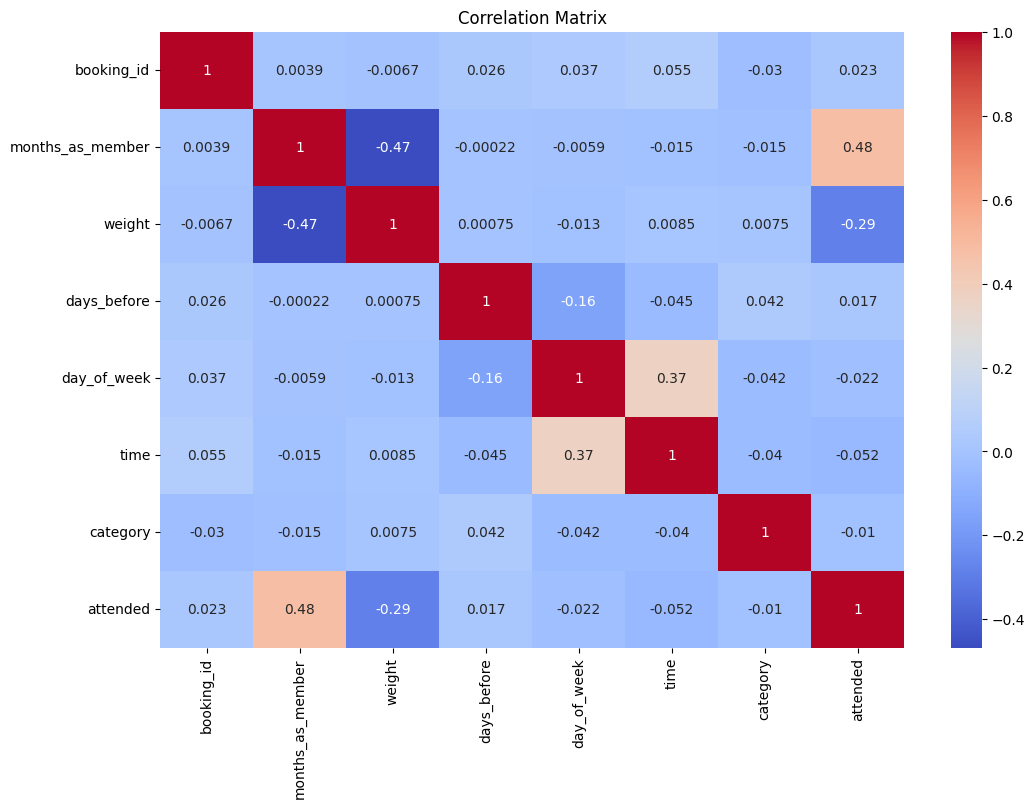

In [115]:
# Plot correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

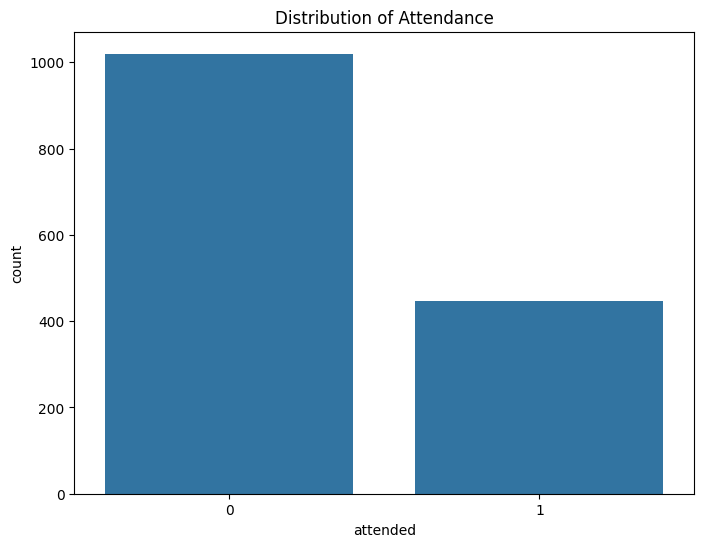

In [116]:
# Plot distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Distribution of Attendance')
plt.show()

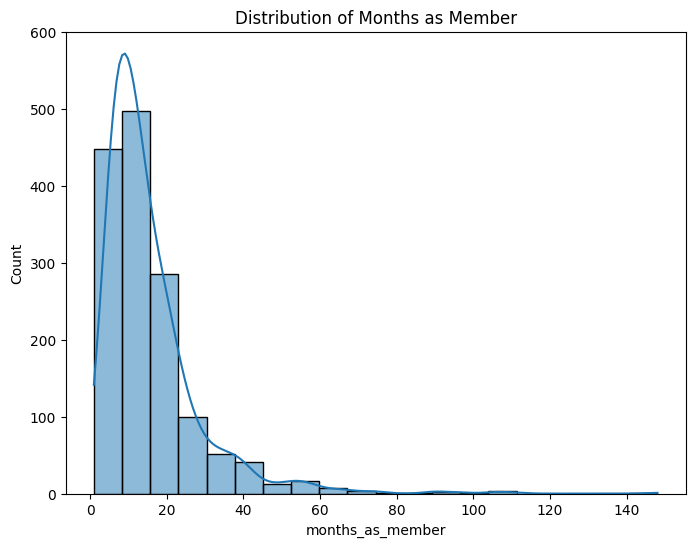

In [117]:
# Plot distribution of 'months_as_member'
plt.figure(figsize=(8, 6))
sns.histplot(data['months_as_member'], bins=20, kde=True)
plt.title('Distribution of Months as Member')
plt.show()

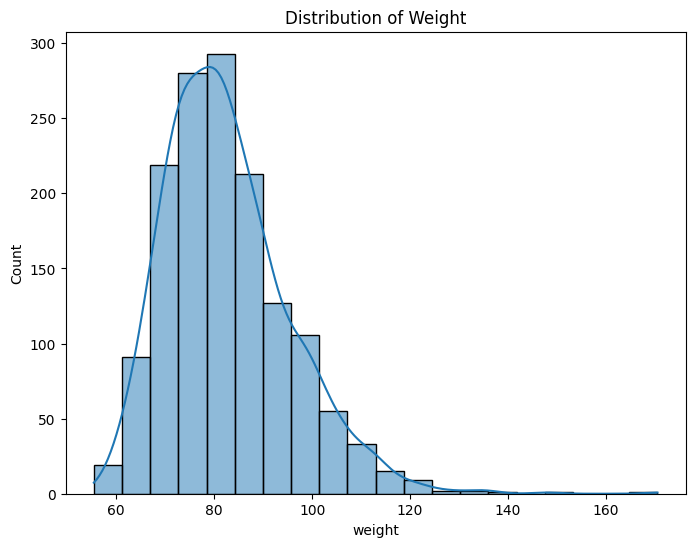

In [118]:
# Plot distribution of 'weight'
plt.figure(figsize=(8, 6))
sns.histplot(data['weight'], bins=20, kde=True)
plt.title('Distribution of Weight')
plt.show()


## Training & Evaluation

In [119]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [120]:
# Display the distribution of the target variable before SMOTE
print("Distribution of y_train before SMOTE:")
print(y_train.value_counts())

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Display the distribution of the target variable after SMOTE
print("\nDistribution of y_train after SMOTE:")
print(y_train_res.value_counts())

Distribution of y_train before SMOTE:
attended
0    809
1    364
Name: count, dtype: int64

Distribution of y_train after SMOTE:
attended
1    809
0    809
Name: count, dtype: int64


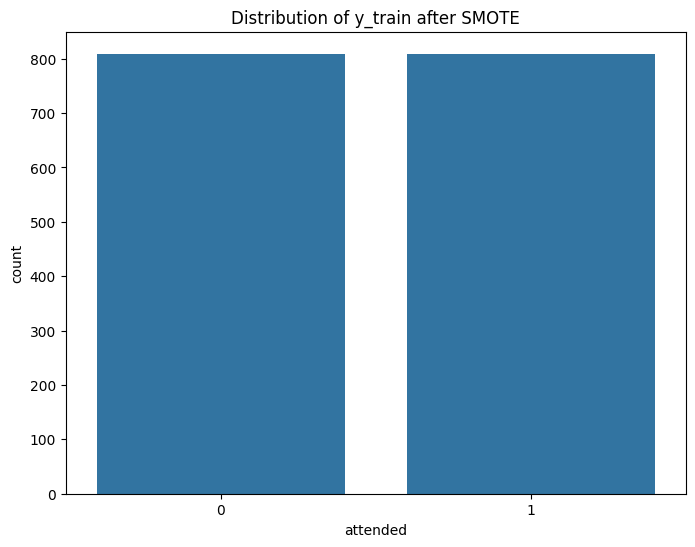

In [121]:
# Plot the distribution of the target variable after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_res)
plt.title('Distribution of y_train after SMOTE')
plt.show()

In [122]:
# Scale the features using RobustScaler
scaler = RobustScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

# Display the shapes of the training and test sets
print("X_train_res shape:", X_train_res.shape)
print("X_test shape:", X_test.shape)
print("y_train_res shape:", y_train_res.shape)
print("y_test shape:", y_test.shape)

X_train_res shape: (1618, 6)
X_test shape: (294, 6)
y_train_res shape: (1618,)
y_test shape: (294,)


In [123]:
# Train and evaluate Logistic Regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_res, y_train_res)
y_pred_logreg = logreg.predict(X_test)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))

Logistic Regression Results:
Accuracy: 0.7482993197278912
Confusion Matrix:
 [[166  45]
 [ 29  54]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82       211
           1       0.55      0.65      0.59        83

    accuracy                           0.75       294
   macro avg       0.70      0.72      0.71       294
weighted avg       0.76      0.75      0.75       294



In [124]:
# Train and evaluate Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Results:
Accuracy: 0.7448979591836735
Confusion Matrix:
 [[173  38]
 [ 37  46]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       211
           1       0.55      0.55      0.55        83

    accuracy                           0.74       294
   macro avg       0.69      0.69      0.69       294
weighted avg       0.75      0.74      0.75       294



In [125]:
# Train and evaluate Support Vector Machine (SVM) model
svm = SVC(random_state=42)
svm.fit(X_train_res, y_train_res)
y_pred_svm = svm.predict(X_test)

print("\nSupport Vector Machine (SVM) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


Support Vector Machine (SVM) Results:
Accuracy: 0.7244897959183674
Confusion Matrix:
 [[158  53]
 [ 28  55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.75      0.80       211
           1       0.51      0.66      0.58        83

    accuracy                           0.72       294
   macro avg       0.68      0.71      0.69       294
weighted avg       0.75      0.72      0.73       294

